<a href="https://colab.research.google.com/github/ML-HW-SYS/a2-MaximClouser/blob/main/6_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **6. Model Pruning**

## 6.0 Setup GDrive and Git

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [ ]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

# %mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
!git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a2-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}"

/content/gdrive/MyDrive/ece5545
fatal: destination path 'a2-MaximClouser' already exists and is not an empty directory.
/content/gdrive/MyDrive/ece5545/a2-MaximClouser
M	src/quant.py
M	tests/test_quant.py
Already on 'main'
Your branch is up to date with 'origin/main'.
Already up to date.
/content/gdrive/MyDrive/ece5545


In [ ]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### GPU: Ensure you are running the GPU runtime type:
1.   Click "Runtime" on top banner
2.   Select "Change runtime type"
3.   Under "Hardware accelarator" select "GPU" and save

### Install required packages

In [ ]:
!pip install torchaudio

### Import code dependencies

In [ ]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import copy

import time

import sys

# Adding assignment1 to the system path-- make sure this matches your git directory
sys.path.insert(0, PROJECT_ROOT)

# Import data_proc to use data processing functions
import src.data_proc as data_proc

# Import constants to use constants defined for training
from src.constants import *

# TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Set random seed
# Make sure the shuffling and picking is deterministic
# Note that different value of random_seed may change rate of variation in loss/accuracy during training
# Using the same random seed value every time you rerun the notebook will
# reproduce the training and testing results
random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

## 6.1 Prepare for Training



In [ ]:
# Create audio_processor
# DATASET_DIR is defined in constants.py
DATASET_DIR = './content/dataset'
# DATASET_DIR = './dataset'
audio_processor = data_proc.AudioProcessor(DATASET_DIR)
print("Audio_processor created")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} to run the training script.')

# Define data loaders
from src.loaders import make_data_loaders
data_loaders = make_data_loaders(audio_processor, device)
train_loader = data_loaders['training']
test_loader = data_loaders['testing']
valid_loader = data_loaders['validation']

# Create a full precision (float32) TinyConv model
from src.networks import TinyConv

model_fp32 = TinyConv(model_settings=audio_processor.model_settings, \
    n_input=1, n_output=audio_processor.num_labels)
model_fp32

Audio_processor created
Using cpu to run the training script.
Train size: 10556 Val size: 1333 Test size: 1368


TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [ ]:
!ls {TORCH_DIR}

 fp32_checkpoint.pt	       MCUmodel0.4.pth	     '(QAT4bit)quant_0.pt'
 fp32_finetune_checkpoint.pt   MCUmodel0.5.pth	     '(QAT6bit)quant_0.pt'
 MCUmodel0.1.pth	       MCUmodel0.6.pth	     '(QAT8bit)quant_0.pt'
 MCUmodel0.2.pth	       MCUmodel0.7.pth	      quant_checkpoint.pt
 MCUmodel0.3.pth	      '(QAT2bit)quant_0.pt'   tinyconv_float32_init_seed0_94.01%_0.pt


### **TODO: Replace the torch_path model with the model you created in the last section.**

You can find the name of your file in `TORCH_DIR` under the folder icon to the left. (Or from running the tab above).

In [ ]:
# TODO: Replace me!
# torch_path = os.path.join(TORCH_DIR, "tinyconv_float32_init_seed0_90.28%_0.pt")
torch_path = "./models/torch_models/tinyconv_float32_init_seed0_94.01%_0.pt"
# Load model
model_fp32.load_state_dict(torch.load(torch_path, map_location=device))
model_fp32

TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

# Finetuning Function

In [ ]:
import time
from src.train_val_test_utils import train
from src.train_val_test_utils import create_optimizer

def run_training(model, data_loaders, n_epoch, optimizer, scheduler=None, verbose=False):
  """
  Trains a given model for a specified number of epochs, used for finetuning pruned models.
  """
  test_loader = data_loaders['testing']
  with tqdm(total=n_epoch) as pbar:
      for epoch in range(n_epoch):

          train(model, data_loaders, optimizer, epoch, device, verbose)

          if scheduler is not None:
              scheduler.step()

          pbar.update(1)

verbose = False
num_batches = len(train_loader)
n_epoch = 8
print(f'#batches: {num_batches} \n#epochs: {n_epoch} \n#total training steps: {num_batches * n_epoch}')

#batches: 106 
#epochs: 8 
#total training steps: 848


## 6.2 Structured Pruning

In this section, you will try to conduct structured pruning on the TinyConv model and explore its effect on performance.
In this notebook, you will be only given minimum scarfolding code. Please take advantages of the code in previous section to faciliate.

Following link will be helpful:
[torch.nn.utils.prune.LnStructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.LnStructured.html?highlight=prune#torch.nn.utils.prune.LnStructured.prune)
[Torch pruning tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html?highlight=prune)

In [ ]:
from src.networks import Reshape

def remove_pruned_channels(old_model, device):
  """
  Removes the pruned channles for a given model after it has been pruned using Torch.
  After removing the pruned channels, the input size to the next layer of the model (fc layer)
  is adjusted accordingly.
  Returns a new model with the pruned channels removed.
  """
  # Create a new model instance
  new_model = TinyConv(old_model.model_settings, n_input=1, n_output=audio_processor.num_labels)
  new_model.to(device)

  # Copy the weights and biases for the conv layer, excluding pruned channels
  conv_weights = old_model.conv.weight.data
  conv_biases = old_model.conv.bias.data

  # Identifying unpruned (non-zero) channels
  non_zero_channels = torch.sum(conv_weights, dim=(1, 2, 3)) != 0
  new_conv_weights = conv_weights[non_zero_channels].to(device)
  new_conv_biases = conv_biases[non_zero_channels].to(device)

  # Updatte conv layer of new model
  new_out_channels = new_conv_weights.shape[0]
  new_model.conv = nn.Conv2d(
      in_channels=new_model.conv.in_channels,
      out_channels=new_out_channels,
      kernel_size=new_model.conv.kernel_size,
      stride=new_model.conv.stride,
      padding=new_model.conv.padding
  ).to(device)
  new_model.conv.weight.data = new_conv_weights
  new_model.conv.bias.data = new_conv_biases

  # Calculate the new input size for the fc layer
  with torch.no_grad():
      mock_input = torch.ones(1, old_model.conv.in_channels, old_model.model_settings['spectrogram_length'], old_model.model_settings['fingerprint_width']).to(device)
      conv_output = new_model.conv(mock_input)
      new_fc_in_features = int(torch.numel(conv_output) / conv_output.size(0))

  # Update the fc_reshape layer to the new shape
  new_model.fc_reshape = Reshape([-1, new_fc_in_features])

  # Adjust the fc layer
  new_model.fc = nn.Linear(in_features=new_fc_in_features, out_features=new_model.fc.out_features).to(device)

  # Copying weights and biases
  old_fc_weights = old_model.fc.weight.data

  new_model.fc.weight.data = old_fc_weights[:, :new_fc_in_features].to(device)
  new_model.fc.bias.data = old_model.fc.bias.data.to(device)

  return new_model

In [ ]:
def get_cpu_runtime(model, input_shape):
  """
  Get the average runtime of a model on the CPU.
  Returns run time in ms.
  """
  model.to('cpu')
  dummy_input = torch.randn(input_shape).to('cpu')

  total_runtime = 0.0
  num_runs = 50
  with torch.no_grad():
      for _ in range(10): # Warm-up runs
          _ = model(dummy_input)

      for _ in range(num_runs):
          start_time = time.time()
          _ = model(dummy_input)
          end_time = time.time()
          total_runtime += end_time - start_time

  average_runtime = total_runtime / num_runs
  return average_runtime * 1000 # Convert to ms

In [ ]:
# Structured channel pruning
def structured_pruning(model, threshold, n_norm):
  """
  Prune channels of a model by a given threshold and Norm.
  After pruning, the torch prune mask and hooks are removed.
  The mask and hooks are removed because the pruned channels will
  be entirely removed from the model later, so there is no need to keep them.
  """
  prune.ln_structured(model.conv, name='weight', amount=threshold, n=n_norm, dim=0) # dim=0 for channels
  prune.remove(model.conv, 'weight')

In [ ]:
# Unstructured pruning
def unstructured_pruning(model, amount_to_prune, remove=False):
  """
  Prune params of the conv and fc layer of a model by a given amount.
  Optionally, after pruning, the prune mask and hooks can be removed.
  The re-parametrization may not be removed if we want to freeze the weights to 0
  for finetuning pruposes.
  """
  for name, module in model.named_modules():
      if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d): # Prune the conv and linear layers
        prune.l1_unstructured(module, name='weight', amount=amount_to_prune)
        if remove:
          prune.remove(module, 'weight')

In [ ]:
from src.size_estimate import flop, count_trainable_parameters

def get_unstructured_params(model):
  """
  Get the number of non-zero parameters in a model by removing the number of pruned params
  from the conv and fc layer from the total number of params in the model.
  """
  zero_count = 0 # number of zero params in the conv and fc layer
  for name, module in model.named_modules():
      if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d): # Only conv and fc layers were pruned
          zero_count += torch.sum(module.weight.data == 0).item()

  total_params = count_trainable_parameters(model)
  return total_params - zero_count

In [ ]:
from src.quant_conversion import compare_model

input_size = (1, 1, model_fp32.model_settings['spectrogram_length'], model_fp32.model_settings['fingerprint_width'])


def prune_and_measure(thresholds, is_structured=True, save_for_mcu=False, n_norm=None):
  """
  For each threshold, prune a model, tune it, and measure the accuracy, params, flops, and runtime.
  Returns dictionaries of accuracies, params, flops, and runtime for each threshold.
  """
  accuracies = {}
  parameters = {}
  flops = {}
  times = {}
  for threshold in thresholds:
    # Create and load new models (one for pre-tune and one for post-tune)
    model_fp32 = TinyConv(model_settings=audio_processor.model_settings, n_input=1, n_output=audio_processor.num_labels)
    model_fp32.load_state_dict(torch.load(torch_path, map_location=device))

    model_fp32_orig = TinyConv(model_settings=audio_processor.model_settings, n_input=1, n_output=audio_processor.num_labels)
    model_fp32_orig.load_state_dict(torch.load(torch_path, map_location=device))

    # Prune the models with given threshold, determine which one to tune
    if is_structured:
      structured_pruning(model_fp32, threshold, n_norm) # Prune masks and hooks are removed from both since channels will be removed
      structured_pruning(model_fp32_orig, threshold, n_norm)
      reduced_model = remove_pruned_channels(model_fp32, device).to(device) # Remove pruned channels
      tuned_model = reduced_model # Tune the reduced model
    else:
      unstructured_pruning(model_fp32, threshold, remove=False) # dont remove for fine tuning
      unstructured_pruning(model_fp32_orig, threshold, remove=True) # remove to count nonzero weights
      tuned_model = model_fp32 # Tune the pruned model with mask and hooks intact

    # Tune the model
    optimizer = create_optimizer(model=tuned_model, learning_rate=0.0001)
    run_training(
      model=tuned_model, data_loaders=data_loaders,
      n_epoch=n_epoch, optimizer=optimizer
    )

    # Save for later testing on MCU
    if is_structured and save_for_mcu:
      model_name = "MCUmodel" + str(threshold) + ".pth"
      path = "./models/torch_models/" + model_name
      torch.save(tuned_model, path)

    # Measure accuracies
    _, pre_tune_acc, post_tune_acc = compare_model(test_loader, model_fp32_orig, tuned_model)
    accuracies[threshold] = (pre_tune_acc, post_tune_acc)

    # Count params
    if is_structured:
      post_tune_parameters = count_trainable_parameters(tuned_model)
      pre_tune_parameters = post_tune_parameters # Same number of params
    else:
      pre_tune_parameters = get_unstructured_params(model_fp32_orig) # Model with mask and hooks removed so it has the actual zero params
      post_tune_parameters = pre_tune_parameters # Same num of params regardless of tuning
    parameters[threshold] = (pre_tune_parameters, post_tune_parameters)

    # Count flops
    model_fp32_orig.to(device)
    if is_structured:
      reduced_flops = flop(tuned_model, input_size, device)
      post_tune_flops = sum([sum(val.values()) for val in reduced_flops.values()])
      pre_tune_flops = post_tune_flops # Same number of flops regardless of tuning
      flops[threshold] = (pre_tune_flops, post_tune_flops)

    # Get run time on CPU
    if is_structured:
      cpu_runtime = get_cpu_runtime(tuned_model, input_size)
      times[threshold] = (cpu_runtime, cpu_runtime) # runtimes are the same regardless of tuning

  return accuracies, parameters, flops, times

In [ ]:
# Get structured pruning measurments
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
n_norm = 1
accuracies, parameters, flops, times = prune_and_measure(thresholds=thresholds, is_structured=True, save_for_mcu=False, n_norm=n_norm)
mcu_times = {0.1: (105, 105), 0.2: (101, 101), 0.3: (99, 99), 0.4: (96, 96), 0.5: (92, 92), 0.6: (87, 87), 0.7: (83, 83)} # Runtime measured on MCU in ms

  0%|          | 0/8 [00:00<?, ?it/s]

Val Acc Epoch 0 = 85.82%, Train loss = 0.576
Val Acc Epoch 1 = 86.12%, Train loss = 0.492
Val Acc Epoch 2 = 85.52%, Train loss = 0.482
Val Acc Epoch 3 = 87.17%, Train loss = 0.468
Val Acc Epoch 4 = 86.5%, Train loss = 0.443
Val Acc Epoch 5 = 87.4%, Train loss = 0.438
Val Acc Epoch 6 = 87.32%, Train loss = 0.431
Val Acc Epoch 7 = 87.32%, Train loss = 0.431
The models have 89.620% same predictions, 
Model1 predicts 84.284% of the samples correctly, 
Model2 predicts 87.792% of the samples correctly


  0%|          | 0/8 [00:00<?, ?it/s]

Val Acc Epoch 0 = 81.32%, Train loss = 1.138
Val Acc Epoch 1 = 83.8%, Train loss = 0.769
Val Acc Epoch 2 = 85.37%, Train loss = 0.661
Val Acc Epoch 3 = 85.6%, Train loss = 0.643
Val Acc Epoch 4 = 86.87%, Train loss = 0.582
Val Acc Epoch 5 = 86.65%, Train loss = 0.562
Val Acc Epoch 6 = 86.8%, Train loss = 0.554
Val Acc Epoch 7 = 87.55%, Train loss = 0.535
The models have 83.041% same predictions, 
Model1 predicts 80.409% of the samples correctly, 
Model2 predicts 86.257% of the samples correctly


  0%|          | 0/8 [00:00<?, ?it/s]

Val Acc Epoch 0 = 81.4%, Train loss = 1.165
Val Acc Epoch 1 = 84.17%, Train loss = 0.74
Val Acc Epoch 2 = 84.77%, Train loss = 0.666
Val Acc Epoch 3 = 86.65%, Train loss = 0.632
Val Acc Epoch 4 = 86.87%, Train loss = 0.595
Val Acc Epoch 5 = 87.55%, Train loss = 0.561
Val Acc Epoch 6 = 87.55%, Train loss = 0.541
Val Acc Epoch 7 = 86.65%, Train loss = 0.537
The models have 83.626% same predictions, 
Model1 predicts 80.190% of the samples correctly, 
Model2 predicts 85.673% of the samples correctly


  0%|          | 0/8 [00:00<?, ?it/s]

Val Acc Epoch 0 = 77.19%, Train loss = 1.2
Val Acc Epoch 1 = 81.4%, Train loss = 0.778
Val Acc Epoch 2 = 84.77%, Train loss = 0.695
Val Acc Epoch 3 = 84.7%, Train loss = 0.629
Val Acc Epoch 4 = 85.22%, Train loss = 0.619
Val Acc Epoch 5 = 86.27%, Train loss = 0.598
Val Acc Epoch 6 = 86.2%, Train loss = 0.572
Val Acc Epoch 7 = 86.57%, Train loss = 0.571
The models have 79.898% same predictions, 
Model1 predicts 75.512% of the samples correctly, 
Model2 predicts 85.161% of the samples correctly


  0%|          | 0/8 [00:00<?, ?it/s]

Val Acc Epoch 0 = 53.26%, Train loss = 1.571
Val Acc Epoch 1 = 67.97%, Train loss = 1.128
Val Acc Epoch 2 = 73.89%, Train loss = 0.979
Val Acc Epoch 3 = 77.64%, Train loss = 0.893
Val Acc Epoch 4 = 79.07%, Train loss = 0.813
Val Acc Epoch 5 = 81.7%, Train loss = 0.778
Val Acc Epoch 6 = 82.6%, Train loss = 0.718
Val Acc Epoch 7 = 82.22%, Train loss = 0.702
The models have 54.605% same predictions, 
Model1 predicts 55.409% of the samples correctly, 
Model2 predicts 83.480% of the samples correctly


  0%|          | 0/8 [00:00<?, ?it/s]

Val Acc Epoch 0 = 60.24%, Train loss = 1.247
Val Acc Epoch 1 = 65.57%, Train loss = 1.087
Val Acc Epoch 2 = 67.89%, Train loss = 1.013
Val Acc Epoch 3 = 67.97%, Train loss = 0.981
Val Acc Epoch 4 = 71.34%, Train loss = 0.946
Val Acc Epoch 5 = 71.79%, Train loss = 0.931
Val Acc Epoch 6 = 72.02%, Train loss = 0.913
Val Acc Epoch 7 = 73.29%, Train loss = 0.9
The models have 54.751% same predictions, 
Model1 predicts 57.968% of the samples correctly, 
Model2 predicts 69.444% of the samples correctly


  0%|          | 0/8 [00:00<?, ?it/s]

Val Acc Epoch 0 = 64.67%, Train loss = 1.09
Val Acc Epoch 1 = 68.64%, Train loss = 1.021
Val Acc Epoch 2 = 70.29%, Train loss = 0.992
Val Acc Epoch 3 = 71.57%, Train loss = 0.962
Val Acc Epoch 4 = 71.64%, Train loss = 0.947
Val Acc Epoch 5 = 72.24%, Train loss = 0.918
Val Acc Epoch 6 = 72.47%, Train loss = 0.906
Val Acc Epoch 7 = 73.74%, Train loss = 0.899
The models have 64.474% same predictions, 
Model1 predicts 55.629% of the samples correctly, 
Model2 predicts 70.395% of the samples correctly


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import numpy as np

def plot_pruning_results(accuracy_dict, params_dict, x_axis_title, color_scheme='scheme0'):
    """
    Plots accuracy vs. parameters, flops, or time for each threshold.
    """
    color_schemes = {
        'scheme0': {'pre_tune': 'blue', 'post_tune': 'green'},
        'scheme1': {'pre_tune': 'darkviolet', 'post_tune': 'limegreen'},
        'scheme2': {'pre_tune': 'darkorange', 'post_tune': 'royalblue'},
        'scheme3': {'pre_tune': 'dodgerblue', 'post_tune': 'crimson'},
        'scheme4': {'pre_tune': 'darkolivegreen', 'post_tune': 'mediumpurple'},
    }
    scheme_colors = color_schemes.get(color_scheme, color_schemes['scheme0'])

    thresholds = sorted(accuracy_dict.keys())
    pre_tune_accuracies = [accuracy_dict[t][0] for t in thresholds]
    post_tune_accuracies = [accuracy_dict[t][1] for t in thresholds]
    pre_tune_params = [params_dict[t][0] for t in thresholds]
    post_tune_params = [params_dict[t][1] for t in thresholds]

    # Create colormap
    cmap = plt.cm.plasma
    min_val, max_val = 0, 0.95
    norm = mcolors.Normalize(vmin=min(thresholds), vmax=max(thresholds))
    threshold_colors = cmap(np.linspace(min_val, max_val, len(thresholds)))

    plt.figure(figsize=(10, 8))

    plt.plot(pre_tune_params, pre_tune_accuracies, color=scheme_colors['pre_tune'], marker='', linestyle='-', label='Not Finetuned')
    plt.plot(post_tune_params, post_tune_accuracies, color=scheme_colors['post_tune'], marker='', linestyle='-', label='Finetuned')

    # Add colored thresholds
    for i, t in enumerate(thresholds):
        plt.scatter(pre_tune_params[i], pre_tune_accuracies[i], color=threshold_colors[i], s=100)
        plt.scatter(post_tune_params[i], post_tune_accuracies[i], color=threshold_colors[i], s=100)

    not_finetuned_legend = Line2D([0], [0], color=scheme_colors['pre_tune'], lw=2, label='Not Finetuned')
    finetuned_legend = Line2D([0], [0], color=scheme_colors['post_tune'], lw=2, label='Finetuned')
    gradient_legend = [Line2D([0], [0], marker='o', color=threshold_colors[i], linestyle='', markersize=10) for i, t in enumerate(thresholds)]
    gradient_labels = [f'Threshold {t}' for t in thresholds]

    plt.xlabel(x_axis_title)
    plt.ylabel('Accuracy')
    plt.title("Accuracy vs. " + x_axis_title)
    plt.legend(handles=[not_finetuned_legend, finetuned_legend, *gradient_legend], labels=['Not Finetuned', 'Finetuned', *gradient_labels])
    plt.grid(True)
    plt.show()

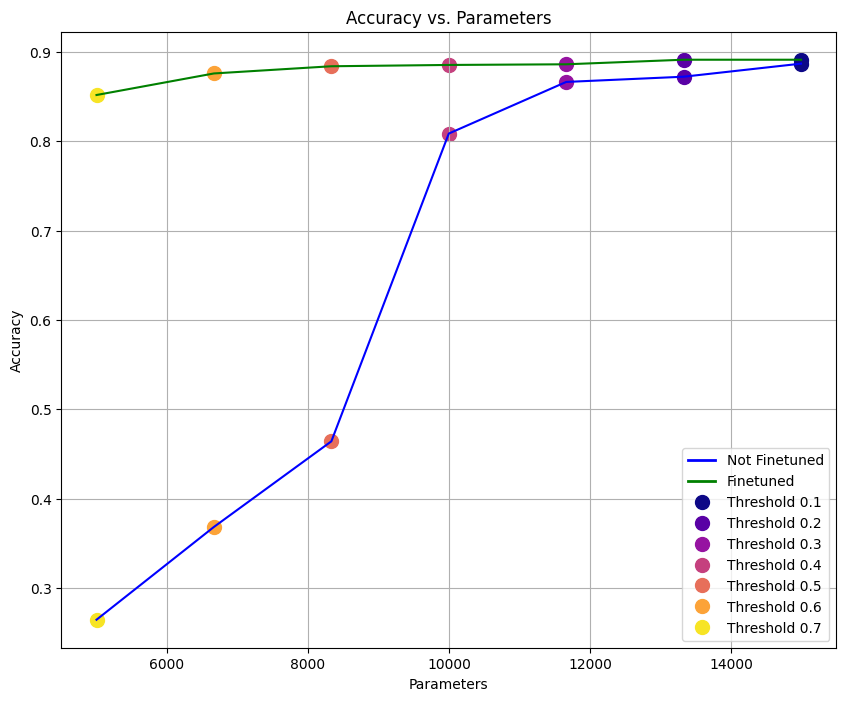

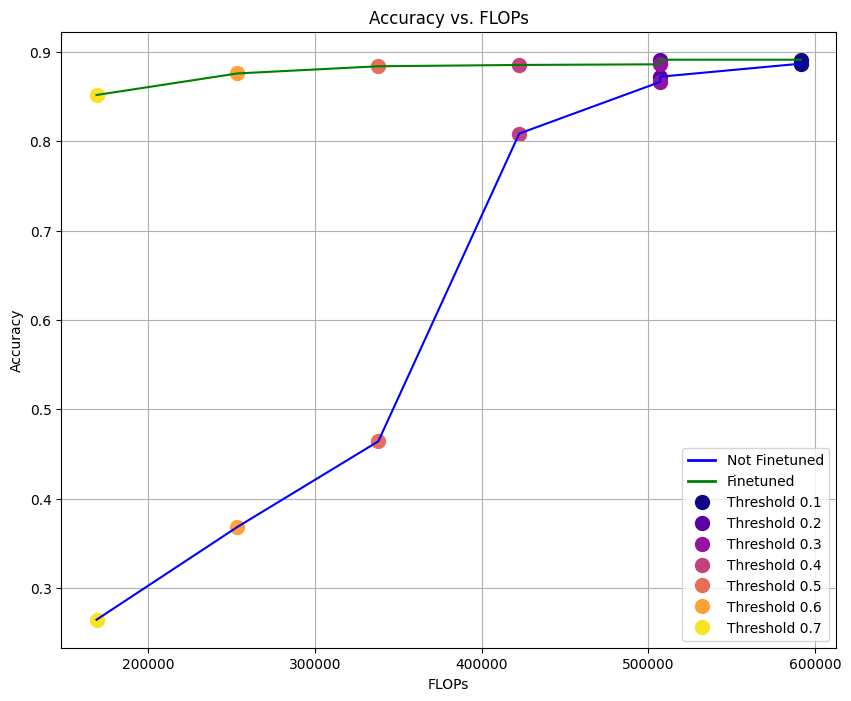

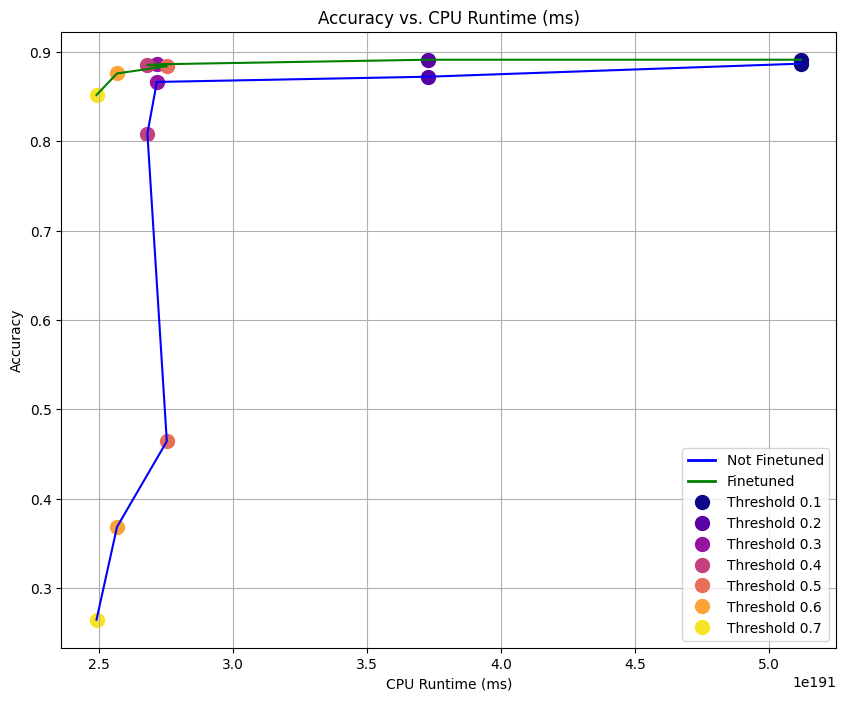

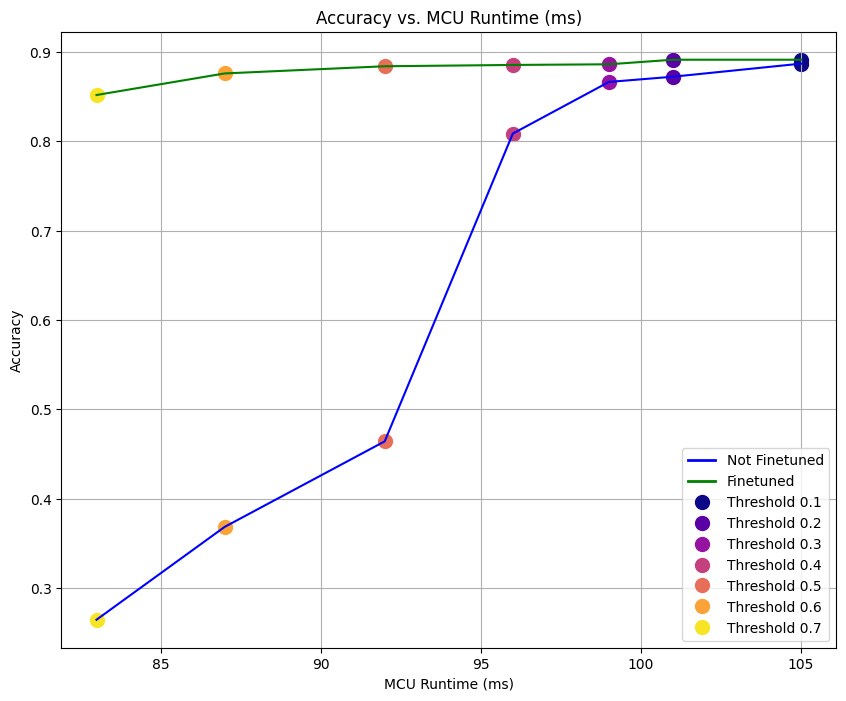

In [ ]:
# Plot structured pruning results
plot_pruning_results(accuracies, parameters, 'Parameters', color_scheme='scheme0')
plot_pruning_results(accuracies, flops, 'FLOPs', color_scheme='scheme0')
plot_pruning_results(accuracies, times, 'CPU Runtime (ms)', color_scheme='scheme0')
plot_pruning_results(accuracies, mcu_times, 'MCU Runtime (ms)', color_scheme='scheme0')

## 6.3 Unstructured Pruning

In this section, you will perform unstructured pruning on the TinyConv model and explore its effect on performance.

Following link will be helpful:
1. [torch.nn.utils.prune.l1_unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.l1_unstructured.html?highlight=unstructured#torch.nn.utils.prune.l1_unstructured)

2. [torch.nn.utils.prune.random_unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.random_unstructured.html?highlight=unstructured#torch.nn.utils.prune.random_unstructured)

2. [Torch pruning tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html?highlight=prune)

In [ ]:
# Get unstructured pruning results
accuracies, parameters, _, _ = prune_and_measure(thresholds=thresholds, is_structured=False)

  0%|          | 0/8 [00:00<?, ?it/s]

Val Acc Epoch 0 = 88.52%, Train loss = 0.451
Val Acc Epoch 1 = 88.67%, Train loss = 0.416
Val Acc Epoch 2 = 88.3%, Train loss = 0.405
Val Acc Epoch 3 = 88.75%, Train loss = 0.392
Val Acc Epoch 4 = 89.65%, Train loss = 0.38
Val Acc Epoch 5 = 89.12%, Train loss = 0.376
Val Acc Epoch 6 = 89.5%, Train loss = 0.367
Val Acc Epoch 7 = 89.42%, Train loss = 0.368
The models have 95.175% same predictions, 
Model1 predicts 88.670% of the samples correctly, 
Model2 predicts 89.108% of the samples correctly


  0%|          | 0/8 [00:00<?, ?it/s]

Val Acc Epoch 0 = 87.77%, Train loss = 0.444
Val Acc Epoch 1 = 88.6%, Train loss = 0.428
Val Acc Epoch 2 = 89.72%, Train loss = 0.397
Val Acc Epoch 3 = 88.75%, Train loss = 0.392
Val Acc Epoch 4 = 88.67%, Train loss = 0.383
Val Acc Epoch 5 = 89.42%, Train loss = 0.386
Val Acc Epoch 6 = 88.82%, Train loss = 0.364
Val Acc Epoch 7 = 89.35%, Train loss = 0.364
The models have 94.371% same predictions, 
Model1 predicts 87.208% of the samples correctly, 
Model2 predicts 89.108% of the samples correctly


  0%|          | 0/8 [00:00<?, ?it/s]

Val Acc Epoch 0 = 88.97%, Train loss = 0.455
Val Acc Epoch 1 = 88.07%, Train loss = 0.412
Val Acc Epoch 2 = 88.6%, Train loss = 0.404
Val Acc Epoch 3 = 88.97%, Train loss = 0.4
Val Acc Epoch 4 = 88.67%, Train loss = 0.389
Val Acc Epoch 5 = 89.35%, Train loss = 0.379
Val Acc Epoch 6 = 88.67%, Train loss = 0.369
Val Acc Epoch 7 = 89.05%, Train loss = 0.365
The models have 93.640% same predictions, 
Model1 predicts 86.623% of the samples correctly, 
Model2 predicts 88.596% of the samples correctly


  0%|          | 0/8 [00:00<?, ?it/s]

Val Acc Epoch 0 = 86.87%, Train loss = 0.486
Val Acc Epoch 1 = 87.92%, Train loss = 0.429
Val Acc Epoch 2 = 87.62%, Train loss = 0.414
Val Acc Epoch 3 = 88.3%, Train loss = 0.402
Val Acc Epoch 4 = 87.92%, Train loss = 0.391
Val Acc Epoch 5 = 89.27%, Train loss = 0.386
Val Acc Epoch 6 = 88.75%, Train loss = 0.378
Val Acc Epoch 7 = 89.27%, Train loss = 0.38
The models have 85.965% same predictions, 
Model1 predicts 80.848% of the samples correctly, 
Model2 predicts 88.523% of the samples correctly


  0%|          | 0/8 [00:00<?, ?it/s]

Val Acc Epoch 0 = 83.72%, Train loss = 1.997
Val Acc Epoch 1 = 86.8%, Train loss = 0.723
Val Acc Epoch 2 = 86.35%, Train loss = 0.519
Val Acc Epoch 3 = 88.52%, Train loss = 0.475
Val Acc Epoch 4 = 87.92%, Train loss = 0.446
Val Acc Epoch 5 = 87.7%, Train loss = 0.436
Val Acc Epoch 6 = 88.52%, Train loss = 0.409
Val Acc Epoch 7 = 88.82%, Train loss = 0.404
The models have 46.418% same predictions, 
Model1 predicts 46.418% of the samples correctly, 
Model2 predicts 88.377% of the samples correctly


  0%|          | 0/8 [00:00<?, ?it/s]

Val Acc Epoch 0 = 76.67%, Train loss = 2.976
Val Acc Epoch 1 = 82.22%, Train loss = 1.088
Val Acc Epoch 2 = 84.55%, Train loss = 0.736
Val Acc Epoch 3 = 86.05%, Train loss = 0.612
Val Acc Epoch 4 = 85.67%, Train loss = 0.519
Val Acc Epoch 5 = 85.82%, Train loss = 0.494
Val Acc Epoch 6 = 86.5%, Train loss = 0.481
Val Acc Epoch 7 = 86.57%, Train loss = 0.475
The models have 34.868% same predictions, 
Model1 predicts 36.842% of the samples correctly, 
Model2 predicts 87.573% of the samples correctly


  0%|          | 0/8 [00:00<?, ?it/s]

Val Acc Epoch 0 = 49.06%, Train loss = 5.71
Val Acc Epoch 1 = 73.22%, Train loss = 2.14
Val Acc Epoch 2 = 79.29%, Train loss = 1.342
Val Acc Epoch 3 = 80.87%, Train loss = 1.063
Val Acc Epoch 4 = 83.87%, Train loss = 0.914
Val Acc Epoch 5 = 83.42%, Train loss = 0.822
Val Acc Epoch 6 = 83.95%, Train loss = 0.742
Val Acc Epoch 7 = 85.82%, Train loss = 0.68
The models have 24.781% same predictions, 
Model1 predicts 26.462% of the samples correctly, 
Model2 predicts 85.161% of the samples correctly


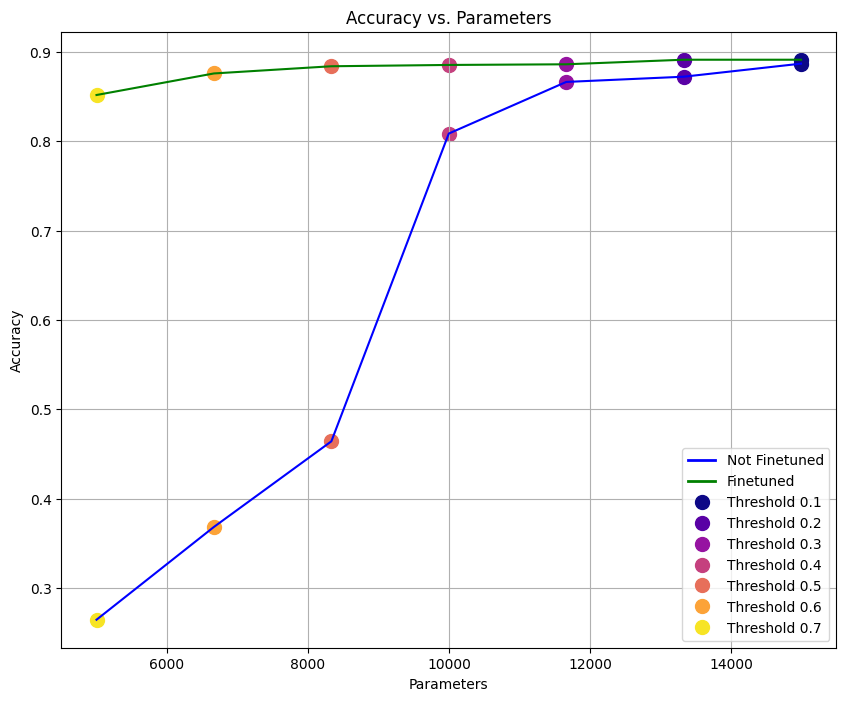

In [ ]:
# Plot unstructured pruning results
plot_pruning_results(accuracies, parameters, 'Parameters', color_scheme='scheme0')